In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.patheffects as pe
# import pyreadstat
# from sklearn_pandas import DataFrameMapper

%matplotlib inline

In [2]:
def list_reader(file,  encoding="utf8"):

    import csv

    with open(file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    data = data[0]

    return data

def list_writer(ur_list, file_name):

    import csv

    with open(file_name, 'w', newline='') as myfile:
         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
         wr.writerow(ur_list)

In [3]:
import random

def add_noise(df,flag,scale=0.1):
    noisy_df = df.copy()
    noise = np.random.uniform(0, scale, size=df.shape)
    
    if flag=='low':       
        noisy_df += noise
        
    else:
        noisy_df -= noise        
        
    return noisy_df

In [4]:
art = np.load('Datasets/Arthritis/Arthritis32_full.npy', allow_pickle=True)
art_meta = pd.read_excel('Datasets/Arthritis/Arthritis_pmeta.xlsx')
cgs=list_reader('Datasets/Arthritis/cgs_full.txt')
art = pd.DataFrame(art, columns=cgs)

In [14]:
shifts = pd.read_pickle('Datasets/Arthritis/shifts.pkl')

In [6]:
#Separate the arthritis dataset by disease state to give them different transformations
art_d = art[art_meta.healthy==1]
art_h = art[art_meta.healthy==0]

In [8]:
#separate each dataframe by high or low beta values to ensure transformations do not go out of [0,1] 
art_dlow = art_d.loc[:,art_d.mean()<0.5]
art_dhi = art_d.loc[:,art_d.mean()>0.5]

art_hlow = art_h.loc[:,art_h.mean()<0.5]
art_hhi = art_h.loc[:,art_h.mean()>0.5]

In [9]:
#transform the lows: add random noise to both disease and healthy

art_dlow = add_noise(art_dlow,'low',scale=0.15)
art_hlow = add_noise(art_hlow,'low',scale=0.17)

#transform the highs
art_dhi = add_noise(art_dhi,'high',scale=0.15)
art_hhi = add_noise(art_hhi,'high',scale=0.17)

In [10]:
#re-combine the columns

art_d=pd.concat([art_dlow, art_dhi], axis=1)
art_d.sort_index(axis=1,inplace=True)

art_h=pd.concat([art_hlow, art_hhi], axis=1)
art_h.sort_index(axis=1,inplace=True)

#re-combine health and disease

toy_data = pd.concat([art_d,art_h],axis=0)
toy_data.sort_index(axis=0,inplace=True)

In [11]:
toy_data.to_pickle('Datasets/Arthritis/toy_arthritis_no_shift.pkl')

In [27]:
toy_data = pd.read_pickle('Datasets/Arthritis/toy_arthritis_no_shift.pkl')

In [47]:
#Separate the arthritis dataset by disease state to give them different transformations
toy_d = toy_data[art_meta.healthy==1]
toy_h = toy_data[art_meta.healthy==0]
d_copy = toy_d.copy()

#Add the average shift to at least the top 1500 CpGs to make the shift more pronounced
for i, cg in enumerate(shifts.CpG[:300]):
    d_copy[cg]+=6*shifts.Shift[i]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [48]:
#re-combine health and disease

toy_data2 = pd.concat([d_copy,toy_h],axis=0)
toy_data2.sort_index(axis=0,inplace=True)

In [49]:
toy_data2.to_pickle('Datasets/Arthritis/toy_arthritis_with_shift.pkl')

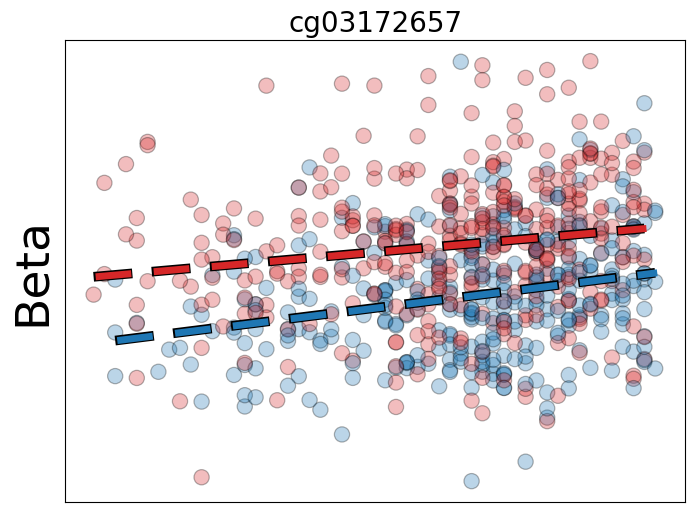

In [175]:
conditions = ['Control', 'Rheumatoid arthritis']

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom_palette = {conditions[0]:blue, conditions[1]:red}

cg='cg03172657' ##up_shift example 
# cg='cg22626683' ##down_shift example

plt.figure(figsize=(8, 6)) 
# Create a scatter plot of the transformed data
sns.scatterplot(x=art_meta.age, y=art[cg] ,hue=art_meta.disease_state, alpha=0.3, s=120, 
                palette =custom_palette, edgecolor='k',legend=False)

sns.regplot(x=art_meta[art_meta.healthy==0].age+0.19, y=art.loc[art_meta.healthy==0][cg], scatter=False,ci=0, color=blue, 
            line_kws={"linestyle": "--","linewidth":5, "dashes":(5.15, 3.24), "zorder":6})
sns.regplot(x=art_meta[art_meta.healthy==0].age, y=art.loc[art_meta.healthy==0][cg], scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})

sns.regplot(x=art_meta[art_meta.healthy==1].age+0.19, y=art.loc[art_meta.healthy==1][cg], scatter=False,ci=0, color=red, 
            line_kws={"linestyle": "--","linewidth":5, "dashes":(5.15, 3.24), "zorder":6})
sns.regplot(x=art_meta[art_meta.healthy==1].age, y=art.loc[art_meta.healthy==1][cg], scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})



# plt.xlabel('Age',fontsize=34)
plt.xlabel(None) ## use for up_shift plot
plt.ylabel('Beta',fontsize=34)
plt.title(cg, fontsize=20)

plt.xticks([]);
plt.yticks([]);
plt.savefig('FSWclock/Figure 4/up_shift.png', dpi=300)

In [183]:
shifts=shifts.sort_values(by='Abs. correlation', ascending=False,ignore_index=True)

In [184]:
shifts

,CpG,Shift,Correlation,Sign,Order,Abs. correlation,Abs. shift
0,cg16867657,-0.009140,0.847155,1,0,0.847155,0.009140
1,cg21572722,-0.013792,0.745844,1,7,0.745844,0.013792
2,cg22454769,0.009697,0.730099,1,3,0.730099,0.009697
3,cg06639320,-0.007488,0.720896,1,1,0.720896,0.007488
4,cg08097417,-0.007874,0.708310,1,27,0.708310,0.007874
...,...,...,...,...,...,...,...
9995,cg16456337,0.011331,0.000061,1,9692,0.000061,0.011331
9996,cg20709868,0.016851,-0.000055,-1,9969,0.000055,0.016851
9997,cg16241861,0.011039,0.000055,1,7272,0.000055,0.011039
9998,cg01585758,-0.002377,0.000037,1,5509,0.000037,0.002377


In [196]:
shifts.iloc[100:150]

,CpG,Shift,Correlation,Sign,Order,Abs. correlation,Abs. shift
100,cg18618815,0.016072,-0.527247,-1,65,0.527247,0.016072
101,cg03738025,-0.048122,0.526055,1,325,0.526055,0.048122
102,cg21911021,-0.019500,0.525321,1,989,0.525321,0.019500
103,cg19560758,-0.016928,0.524953,1,192,0.524953,0.016928
104,cg18473521,-0.020037,0.524627,1,585,0.524627,0.020037
105,cg12189835,-0.010484,0.524174,1,4325,0.524174,0.010484
106,cg26166595,0.014559,-0.523440,-1,2428,0.523440,0.014559
107,cg08262002,0.002820,-0.522498,-1,30,0.522498,0.002820
108,cg25478614,-0.004294,0.522136,1,366,0.522136,0.004294
109,cg11807280,-0.025424,-0.520523,-1,278,0.520523,0.025424


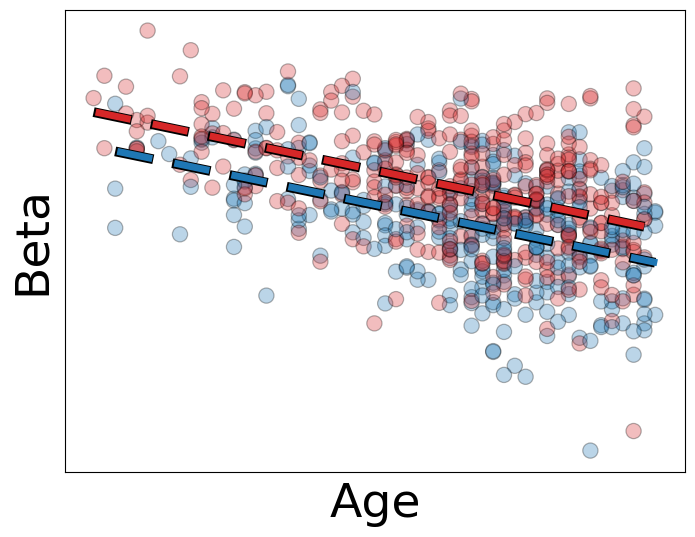

In [201]:
conditions = ['Control', 'Rheumatoid arthritis']

blue = sns.color_palette()[0]
red=sns.color_palette()[3]

custom_palette = {conditions[0]:blue, conditions[1]:red}

cg=shifts.CpG[96] 

plt.figure(figsize=(8, 6)) 
# Create a scatter plot of the transformed data
sns.scatterplot(x=art_meta.age, y=1-toy_data[cg] ,hue=art_meta.disease_state, alpha=0.3, s=120, 
                palette =custom_palette, edgecolor='k',legend=False)

sns.regplot(x=art_meta[art_meta.healthy==0].age+0.19, y=1-toy_data.loc[art_meta.healthy==0][cg], scatter=False,ci=0, color=blue, 
            line_kws={"linestyle": "--","linewidth":5, "dashes":(5.15, 3.24), "zorder":6})
sns.regplot(x=art_meta[art_meta.healthy==0].age, y=1-toy_data.loc[art_meta.healthy==0][cg], scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})

sns.regplot(x=art_meta[art_meta.healthy==1].age+0.19, y=1-toy_data.loc[art_meta.healthy==1][cg], scatter=False,ci=0, color=red, 
            line_kws={"linestyle": "--","linewidth":5, "dashes":(5.15, 3.24), "zorder":6})
sns.regplot(x=art_meta[art_meta.healthy==1].age, y=1-toy_data.loc[art_meta.healthy==1][cg], scatter=False,ci=0, color='k',
            line_kws={"linestyle": "--","linewidth":7, "dashes":(4, 2), "zorder":5})


plt.xlabel('Age',fontsize=34)
# plt.xlabel(None) ##For downs shift
plt.ylabel('Beta',fontsize=34)

plt.xticks([]);
plt.yticks([]);
plt.savefig('FSWclock/Figure 4/4c upshift.png', dpi=300)